In [ ]:
# train an NER model with BERT, pipeline adapted from https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

## Install transformers library

In [42]:
# Install required dependencies
!pip install transformers

## Data preprocessing

In [43]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

torch.__version__

'1.9.0+cu102'

In [44]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/~Classes/NER_data/')
!ls

bert_ner_model.bin	 ner_dataset.csv       ner_state_dict.bin
bert_ner_model_test.bin  ner_state_dict_2.bin
ner_bert_model.bin	 ner_state_dict_3.bin


In [46]:
# read in the pandas dataframe of named entities
data = pd.read_csv("ner_dataset.csv", encoding="latin1").fillna(method="ffill")
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [47]:
# define a rudimentary dataset class
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
                                                           
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [51]:
# collate all the sentences appropriately
getter = SentenceGetter(data)
#train_sentences, val_sentences = train_test_split(getter.sentences, random_state=2018, test_size=0.1)

In [52]:
# check an example sentence
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [53]:
# collate the labels appropriately
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[4])


['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-gpe', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [54]:
# obtain all the unique tokens for the finetuning layer
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}


In [55]:
# set your maximum sequence length and batch size
MAX_LEN =  150
bs = 32

In [56]:
# define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()


In [57]:
torch.cuda.get_device_name(0)


'Tesla P100-PCIE-16GB'

In [58]:
# obtain the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


In [59]:
# tokenize all the sentences according to the tokenizer defined above
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [60]:
# tokenize the data
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]


In [61]:
# obtain the tokenized texts and labels
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
print(len(tokenized_texts))


47959


In [62]:
# pad the sequences to the desired length defined above
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [63]:
# labels with padding
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [64]:
# attention masks for excluding the padded parts
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


In [65]:
# train/test split on inputs/labels
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# train/test split on attention masks
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [66]:
# turning everything into a torch tensor
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [67]:
val_inputs.shape

torch.Size([4796, 150])

In [68]:
# creating dataloaders
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


## Model training

In [31]:

import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.9.0'

In [32]:

model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [33]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [34]:
# check the inputs and outputs of the finetuning layers
model.classifier

Linear(in_features=768, out_features=18, bias=True)

In [35]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [36]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [37]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=cb05515bd0facd1de9b4a8274f8593acc6a2587f4b51d7d0f12b628a590205a6
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [38]:
from seqeval.metrics import f1_score, accuracy_score, classification_report
from seqeval.scheme import IOB2


In [39]:
!ls

bert_ner_model.bin	 ner_dataset.csv       ner_state_dict.bin
bert_ner_model_test.bin  ner_state_dict_2.bin
ner_bert_model.bin	 ner_state_dict_3.bin


In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    #print("Classification report:")
    #(classification_report(valid_tags, pred_tags, mode="strict", scheme=IOB2))
    print("Saving out model checkpoint")
    torch.save(
        {"epochs": epochs,
         "model_state_dict": model.state_dict(),
         "tag_values": tag_values},
         "bert_ner_model.bin"
    )



Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.12699509910504583
Validation loss: 0.1262559526413679
Validation Accuracy: 0.9609297806468612
Validation F1-Score: 0.8248404781162938
Saving out model checkpoint



Epoch:  33%|███▎      | 1/3 [11:06<22:13, 666.79s/it]

Average train loss: 0.09039423137549739
Validation loss: 0.12872629483540854
Validation Accuracy: 0.9618437520584942
Validation F1-Score: 0.8289387144992526
Saving out model checkpoint



Epoch:  67%|██████▋   | 2/3 [22:12<11:06, 666.57s/it]

Average train loss: 0.06551725536328033
Validation loss: 0.13277332426359256
Validation Accuracy: 0.9628729991436664
Validation F1-Score: 0.8333879472132026
Saving out model checkpoint



Epoch: 100%|██████████| 3/3 [33:18<00:00, 666.10s/it]


In [ ]:
f1_score(pred_tags_list, valid_tags_list)

0.809153894604241

In [ ]:
print(len(valid_tags))
print(len(pred_tags))

121448
121448


In [ ]:
print(classification_report([valid_tags], [pred_tags], mode="strict", scheme=IOB2))

              precision    recall  f1-score   support

         art       0.33      0.20      0.25        95
         eve       0.35      0.36      0.36        36
         geo       0.86      0.90      0.88      5963
         gpe       0.95      0.93      0.94      1783
         nat       0.90      0.24      0.38        37
         org       0.78      0.72      0.75      3667
         per       0.81      0.81      0.81      2813
         tim       0.86      0.83      0.84      2347

   micro avg       0.84      0.83      0.84     16741
   macro avg       0.73      0.63      0.65     16741
weighted avg       0.84      0.83      0.83     16741



In [ ]:
pred_tags_list = [pred_tags]
valid_tags_list = [valid_tags]
print(classification_report(valid_tags_list, pred_tags_list, mode="strict", scheme=IOB2))



              precision    recall  f1-score   support

         art       0.00      0.00      0.00        95
         eve       0.25      0.22      0.24        36
         geo       0.84      0.89      0.86      5963
         gpe       0.92      0.91      0.91      1783
         nat       1.00      0.03      0.05        37
         org       0.77      0.65      0.70      3667
         per       0.79      0.80      0.79      2813
         tim       0.85      0.79      0.82      2347

   micro avg       0.82      0.80      0.81     16741
   macro avg       0.68      0.54      0.55     16741
weighted avg       0.82      0.80      0.81     16741



In [ ]:
len(valid_tags_list[0])

121448

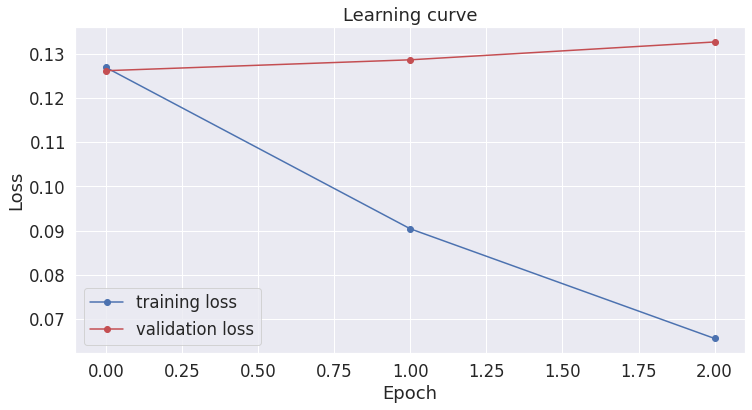

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


## Do inference

Note: the below is not tested well, for loading a pretrained model into memory and performing inference, see the script `inference.py`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/~Classes/NER_data/')
!ls

bert_ner_model.bin  ner_dataset.csv	  ner_state_dict_3.bin
ner_bert_model.bin  ner_state_dict_2.bin  ner_state_dict.bin


In [ ]:
!pip install transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, DistilBertTokenizerFast, BertConfig
from transformers import BertForTokenClassification, AdamW

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

torch.__version__

'1.9.0+cu102'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


In [ ]:
tokenizer_db = DistilBertTokenizerFast.from_pretrained(
        "distilbert-base-cased", do_lower_case=False
    )

In [ ]:
model_cpu = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=18,
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1").fillna(method="ffill")
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
tag_values

['I-gpe',
 'I-nat',
 'O',
 'I-art',
 'B-nat',
 'B-eve',
 'B-geo',
 'I-org',
 'B-tim',
 'I-tim',
 'B-art',
 'I-per',
 'I-eve',
 'B-org',
 'B-gpe',
 'B-per',
 'I-geo',
 'PAD']

In [ ]:
tag_values = ['B-org',
 'B-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'B-per',
 'I-tim',
 'B-gpe',
 'I-geo',
 'B-art',
 'I-gpe',
 'I-nat',
 'O',
 'I-org',
 'I-art',
 'I-per',
 'B-geo',
 'PAD']

In [ ]:
device = torch.device('cpu')
checkpoint = torch.load("bert_ner_model.bin", map_location=device)
tag_values = checkpoint["tag_values"]
model_cpu.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [ ]:
model_cpu.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
test_sentence = """
Divy’s tweets began just moments after a International Atomic Agency diatribe by this randome Mike dude, a 
reporter for the network, about pangolins in Germany on Wednesday afternoon in June and elsewhere. 
"""


In [ ]:
encoding = tokenizer_db(test_sentence, padding=True, truncation=True, add_special_tokens=False, return_tensors="pt", return_offsets_mapping=True)

In [ ]:
encoding

{'input_ids': tensor([[12120,  7170,   787,   188,   189, 24887,  1116,  1310,  1198,  4899,
          1170,   170,  1570, 18662,  5571,  4267,  2980,  2047,  3962,  1118,
          1142,  7091,  1162,  2639, 17869,   117,   170,  6672,  1111,  1103,
          2443,   117,  1164, 13316, 26603,  4935,  1107,  1860,  1113,  9031,
          4427,  1107,  1340,  1105,  6890,   119]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'offset_mapping': tensor([[[  1,   3],
         [  3,   5],
         [  5,   6],
         [  6,   7],
         [  8,   9],
         [  9,  13],
         [ 13,  14],
         [ 15,  20],
         [ 21,  25],
         [ 26,  33],
         [ 34,  39],
         [ 40,  41],
         [ 42,  55],
         [ 56,  62],
         [ 63,  69],
         [ 70,  72],
         [ 72,  74],
         [ 74,  76],
         [ 76,  78],
         [ 79,  81],
 

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence, padding=False)
input_ids = torch.tensor([tokenized_sentence])


In [ ]:
len(input_ids[0])

48

In [ ]:
input_ids[0]

tensor([  101, 12120,  7170,   787,   188,   189, 24887,  1116,  1310,  1198,
         4899,  1170,   170,  1570, 18662,  5571,  4267,  2980,  2047,  3962,
         1118,  1142,  7091,  1162,  2639, 17869,   117,   170,  6672,  1111,
         1103,  2443,   117,  1164, 13316, 26603,  4935,  1107,  1860,  1113,
         9031,  4427,  1107,  1340,  1105,  6890,   119,   102])

In [ ]:
input_ids.device

device(type='cpu')

In [ ]:
with torch.no_grad():
    output = model_cpu.forward(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [ ]:
label_indices

array([[ 7,  1,  1,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  3, 15, 15,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7, 10,  7,  6,  5,  5,  5,  7,  7,  7,  7]])

In [ ]:
label_indices.shape

(1, 48)

In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
B-per	Divy
O	’
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	International
I-org	Atomic
I-org	Agency
O	diatribe
O	by
O	this
O	randome
O	Mike
O	dude
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	pangolins
O	in
B-geo	Germany
O	on
B-tim	Wednesday
I-tim	afternoon
I-tim	in
I-tim	June
O	and
O	elsewhere
O	.
O	[SEP]


In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
B-per	Mr
B-per	.
I-per	Trump
O	’
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	Fox
I-org	News
O	report
O	by
B-per	Mike
I-per	Tobin
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	protests
O	in
B-geo	Minnesota
O	and
O	elsewhere
O	.
O	[SEP]
